# Dreambooth
### Implémentation originale du notebook par Joe Penna (@MysteryGuitarM sur Twitter) - Améliorations par David Bielejeski et Léo "Desp" (@Desp_OnChain sur Twitter)

Pour plus d'informations, voir le README de:
https://github.com/Desp-OnChain/Dreambooth-Stable-Diffusion-FR

## Instructions
- Tout d'abord, suivez les instructions présentées dans ce thread: //Ajouter lien du thread
- Ensuite, remplissez la cellule intitulée *A COMPLETER* ci-dessous avec vos valeurs comme décrit ci-dessous

### Récupérez votre token d'authentification sur huggingface

- Connectez-vous à votre compte HuggingFace
- Acceptez les termes d'utilisations du modèle à l'adresse suivante: https://huggingface.co/CompVis/stable-diffusion-v-1-4-original
- Rendez vous ici: https://huggingface.co/settings/tokens
- Cliquez sur New Token, donnez lui un nom, mettez le role à `read` puis cliquez sur Generate a token
- Copiez ensuite ce token et remplacez `Mon_token` par votre token dans la cellule suivante.

### Uploadez vos images d'entrainement
Uploadez 10-20 images de quelqu'un sur imgur, et ajoutez les lien directs vers les images à la liste d'urls en respectant le format indiqué.
ATTENTION: Faites attention à bien utiliser un nombre pair d'images sinon l'entrainement s'arrête à 1500 étapes.
Il faut environ:

*   2-3 corps complet
*   3-5 haut du corps
*   5-12 visage

Les images doivent être:

- Similaires au genre d'images que vous souhaitez générer (donc pas de selfies la plupart du temps).
- Autant différentes les unes des autres que possible (dans le contexte, la position du sujet, etc).

### Indiquez votre token et votre classe

Remplacez 'gusfring' et 'person' par le nom et la classe désirée, par exemple 'felix' et 'cat' si vous voulez générer des images d'un chat appelé felix.
Si vous changez la classe, remplacez également `person = True` par `person = False`, ce qui permettra de générer de nouvelles images de régularisation.

### Etapes d'entrainement

Libre à vous d'ajouster le nombre d'étapes d'entrainement pour voir si cela peut améliorer vos résultats.

### Finalement, cliquez sur l'icone constituée de deux triangles ci-dessus en haut de l'onglet, située entre la flèche circulaire et le mot markdown.

# A COMPLETER

In [46]:
# Ajoutez ici votre token d'identification HuggingFace
auth_token = "Mon_token"


#Ajoutez ici les urls de vos images
urls = [
    "https://i.imgur.com/lien.jpg",
    "https://i.imgur.com/lien.jpg",
    "https://i.imgur.com/lien.jpg",
    "https://i.imgur.com/lien.jpg",
    "https://i.imgur.com/lien.jpg",
    "https://i.imgur.com/lien.jpg",
    "https://i.imgur.com/lien.jpg",
    "https://i.imgur.com/lien.jpg",
    "https://i.imgur.com/lien.jpg",
    "https://i.imgur.com/lien.jpg",
 # Vous pouvez ajoutez plus d'images ici en suivant le même principe: lien entre guillemets suivi d'une virgule 
]

# Remplacez le nom entre guillemets par le nom que vous voulez
my_token = 'gusfring'

# Si votre sujet est une personne, laissez 'person', sinon remplacez avec le nom de votre classe en anglais (ex: 'dog' si votre sujet est un chien)
my_class = 'person'

# Si vous avez modifié la classe juste au dessis, remplacez ici True par False
person = True

# Nombre d'étapes d'entrainement, vous pouvez laisser cette valeur ou la modifier pour essayer d'améliorer vos résultats
max_training_steps = 1616

## Création de l'environnement

In [1]:
#BUILD ENV
!pip install omegaconf
!pip install einops
!pip install pytorch-lightning==1.6.5
!pip install test-tube
!pip install transformers
!pip install kornia
!pip install -e git+https://github.com/CompVis/taming-transformers.git@master#egg=taming-transformers
!pip install -e git+https://github.com/openai/CLIP.git@main#egg=clip
!pip install setuptools==59.5.0
!pip install pillow==9.0.1
!pip install torchmetrics==0.6.0
!pip install -e .
!pip install protobuf==3.20.1
!pip install gdown
!pip install pydrive
!pip install -qq diffusers["training"]==0.3.0 transformers ftfy
!pip install -qq "ipywidgets>=7,<8"
!pip install huggingface_hub
!pip install ipywidgets==7.7.1

Obtaining taming-transformers from git+https://github.com/CompVis/taming-transformers.git@master#egg=taming-transformers
  Updating ./src/taming-transformers clone (to revision master)
  Attempting uninstall: taming-transformers
    Found existing installation: taming-transformers 0.0.1
    Uninstalling taming-transformers-0.0.1:
      Successfully uninstalled taming-transformers-0.0.1
  Running setup.py develop for taming-transformers
Obtaining clip from git+https://github.com/openai/CLIP.git@main#egg=clip
  Updating ./src/clip clone (to revision main)
  Attempting uninstall: clip
    Found existing installation: clip 1.0
    Uninstalling clip-1.0:
      Successfully uninstalled clip-1.0
  Running setup.py develop for clip
Obtaining file:///workspace/Dreambooth-Stable-Diffusion
  Attempting uninstall: latent-diffusion
    Found existing installation: latent-diffusion 0.0.1
    Uninstalling latent-diffusion-0.0.1:
      Successfully uninstalled latent-diffusion-0.0.1
  Running setup.py

In [3]:
## Téléchargement du modèle
from huggingface_hub import hf_hub_download
downloaded_model_path = hf_hub_download(
 repo_id="CompVis/stable-diffusion-v-1-4-original",
 filename="sd-v1-4.ckpt",
 use_auth_token=auth_token
)

Downloading:   0%|          | 0.00/4.27G [00:00<?, ?B/s]

Si un message indiquant "Click to show javascript error." s'affiche ci-dessus, ne vous en faites pas c'est seulement une erreur d'affichage, vous pouvez l'ignorer ou rafraîchir la page pour résoudre le problème.

In [4]:
## Déplacement et renommage du modèle "model.ckpt"
actual_locations_of_model_blob = !readlink -f {downloaded_model_path}
!mv {actual_locations_of_model_blob[-1]} model.ckpt

# Images de régularisation

L'entrainement apprend votre token au modèle **mais** ré-entraine également la classe.

Après tests, il sembleraient que les images de reg n'affectent pas trop le modèle. Cependant, elles affectent énormément votre classe, ce qui va donc affecter vos générations.

Vous pouvez soit générer vos images, soit utiliser les repos ci-dessous pour rapidement générer 1500 images.

## Téléchargement des images de régularisation pré-générées

L'équipe de Joe a créé les ensembles d'images suivants:

* man_euler - fourni par Niko Pueringer (Corridor Digital) - euler @ 40 steps, CFG 7.5
* man_unsplash - images de différents photographes
* person_ddim
* woman_ddim - fourni par David Bielejeski - ddim @ 50 steps, CFG 10.0

`person_ddim` recommandé

In [48]:
# Récupération des images de régularisation
if person:
    dataset="person_ddim"
    !git clone https://github.com/djbielejeski/Stable-Diffusion-Regularization-Images-{dataset}.git

    !mkdir -p outputs/txt2img-samples/samples/{dataset}
    !mv -v Stable-Diffusion-Regularization-Images-{dataset}/{dataset}/*.* outputs/txt2img-samples/samples/{dataset}
else:
    !python scripts/stable_txt2img.py \
     --seed 10 \
     --ddim_eta 0.0 \
     --n_samples 1 \
     --n_iter 200 \
     --scale 10.0 \
     --ddim_steps 50 \
     --ckpt model.ckpt \
     --prompt {my_class}
    !apt-get install -y zip
    !zip -r all_images.zip outputs/

fatal: destination path 'Stable-Diffusion-Regularization-Images-person_ddim' already exists and is not an empty directory.
mv: cannot stat 'Stable-Diffusion-Regularization-Images-person_ddim/person_ddim/*.*': No such file or directory


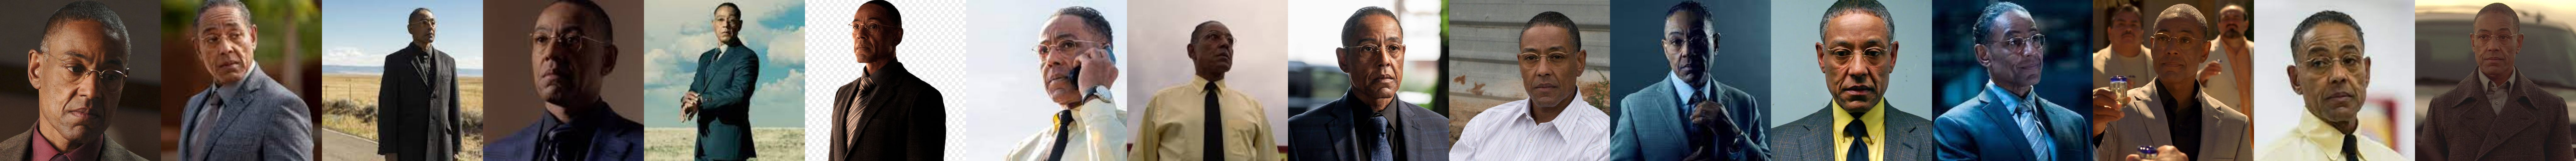

In [9]:
#@title Download and check the images you have just added
import os
import requests
from io import BytesIO
from PIL import Image


def image_grid(imgs, rows, cols):
 assert len(imgs) == rows*cols

 w, h = imgs[0].size
 grid = Image.new('RGB', size=(cols*w, rows*h))
 grid_w, grid_h = grid.size

 for i, img in enumerate(imgs):
  grid.paste(img, box=(i%cols*w, i//cols*h))
 return grid

def download_image(url):
 try:
  response = requests.get(url)
 except:
  return None
 return Image.open(BytesIO(response.content)).convert("RGB")

images = list(filter(None,[download_image(url) for url in urls]))
save_path = "./training_samples"
if not os.path.exists(save_path):
 os.mkdir(save_path)
[image.save(f"{save_path}/{i}.png", format="png") for i, image in enumerate(images)]
image_grid(images, 1, len(images))

# Entrainement

Si vous entrainez sur une personne ou un sujet, faites attention aux images générées ici: `logs/{folder}/images/train/samples_scaled_gs-00xxxx`

Si vous entrainez sur un style, surveillez ce dossier: `logs/{folder}/images/train/samples_gs-00xxxx`

### Modification du fichier personalized.py

Joe recommande d'utiliser le nom d'une célébrité qui:
1) vous ressemble un peu.
2) est bien générée par Stable Diffusion (vous pouvez vérifier en tapant son nom sur DreamStudio)

In [43]:
%%writefile ldm/data/personalized.py
# %load ldm/data/personalized.py
import os
import numpy as np
import PIL
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms

import random

training_templates_smallest = [
    my_token + ' {}',
]

reg_templates_smallest = [
    '{}',
]

imagenet_templates_small = [

    '{}',
]

imagenet_dual_templates_small = [
    '{} with {}'
]

per_img_token_list = [
    'א', 'ב', 'ג', 'ד', 'ה', 'ו', 'ז', 'ח', 'ט', 'י', 'כ', 'ל', 'מ', 'נ', 'ס', 'ע', 'פ', 'צ', 'ק', 'ר', 'ש', 'ת',
]


class PersonalizedBase(Dataset):
    def __init__(self,
                 data_root,
                 size=None,
                 repeats=100,
                 interpolation="bicubic",
                 flip_p=0.0,
                 set="train",
                 placeholder_token="dog",
                 per_image_tokens=False,
                 center_crop=False,
                 mixing_prob=0.25,
                 coarse_class_text=None,
                 reg=False
                 ):

        self.data_root = data_root

        self.image_paths = [os.path.join(
            self.data_root, file_path) for file_path in os.listdir(self.data_root)]

        # self._length = len(self.image_paths)
        self.num_images = len(self.image_paths)
        self._length = self.num_images

        self.placeholder_token = placeholder_token

        self.per_image_tokens = per_image_tokens
        self.center_crop = center_crop
        self.mixing_prob = mixing_prob

        self.coarse_class_text = coarse_class_text

        if per_image_tokens:
            assert self.num_images < len(
                per_img_token_list), f"Can't use per-image tokens when the training set contains more than {len(per_img_token_list)} tokens. To enable larger sets, add more tokens to 'per_img_token_list'."

        if set == "train":
            self._length = self.num_images * repeats

        self.size = size
        self.interpolation = {"linear": PIL.Image.LINEAR,
                              "bilinear": PIL.Image.BILINEAR,
                              "bicubic": PIL.Image.BICUBIC,
                              "lanczos": PIL.Image.LANCZOS,
                              }[interpolation]
        self.flip = transforms.RandomHorizontalFlip(p=flip_p)
        self.reg = reg

    def __len__(self):
        return self._length

    def __getitem__(self, i):
        example = {}
        image = Image.open(self.image_paths[i % self.num_images])

        if not image.mode == "RGB":
            image = image.convert("RGB")

        placeholder_string = self.placeholder_token
        if self.coarse_class_text:
            placeholder_string = f"{self.coarse_class_text} {placeholder_string}"

        if not self.reg:
            text = random.choice(training_templates_smallest).format(
                placeholder_string)
        else:
            text = random.choice(reg_templates_smallest).format(
                placeholder_string)

        example["caption"] = text

        # default to score-sde preprocessing
        img = np.array(image).astype(np.uint8)

        if self.center_crop:
            crop = min(img.shape[0], img.shape[1])
            h, w, = img.shape[0], img.shape[1]
            img = img[(h - crop) // 2:(h + crop) // 2,
                      (w - crop) // 2:(w + crop) // 2]

        image = Image.fromarray(img)
        if self.size is not None:
            image = image.resize((self.size, self.size),
                                 resample=self.interpolation)

        image = self.flip(image)
        image = np.array(image).astype(np.uint8)
        example["image"] = (image / 127.5 - 1.0).astype(np.float32)
        return example


['gusfring {}']


## Lancement de l'entrainement

In [25]:
# DEBUT DE L'ENTRAINEMENT
project_name = my_token

reg_data_root = "/workspace/Dreambooth-Stable-Diffusion/outputs/txt2img-samples/samples/" + dataset

!rm -rf training_samples/.ipynb_checkpoints
!python "main.py" \
 --base configs/stable-diffusion/v1-finetune_unfrozen.yaml \
 -t \
 --actual_resume "model.ckpt" \
 --reg_data_root {reg_data_root} \
 -n {project_name} \
 --gpus 0, \
 --data_root "/workspace/Dreambooth-Stable-Diffusion/training_samples" \
 --max_training_steps {max_training_steps} \
 --class_word {my_class} \
 --no-test

Global seed set to 23
Running on GPUs 0,
Loading model from model.ckpt
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 64, 64) = 16384 dimensions.
making attention of type 'vanilla' with 512 in_channels
Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.2.layer_norm1.bias', 'vision_model.encoder.layers.11.self_attn.k_proj.bias', 'vision_model.encoder.layers.10.layer_norm1.weight', 'visual_projection.weight', 'vision_model.encoder.layers.21.self_attn.v_proj.bias', 'vision_model.encoder.layers.1.mlp.fc2.bias', 'vision_model.encoder.layers.2.self_attn.q_proj.bias', 'vision_model.encoder.layers.0.mlp.fc2.bias', 'vision_model.encoder.layers.14.mlp.fc1.weight', 'vision_model.encoder.layers.10.self_attn.out_proj.weight', 'vision_model.encoder.layers.13.self_attn.out_proj.bias

## Pruning (de 12GB à 2GB)
Réduction de la taille du modèle

In [26]:
directory_paths = !ls -d logs/*

In [27]:
# Cette version réduit d'environ 10GB le fichier ckpt
last_checkpoint_file = directory_paths[-1] + "/checkpoints/last.ckpt"
!python "prune_ckpt.py" --ckpt {last_checkpoint_file}

prunin' in path: logs/training_samples2022-10-04T09-17-18_gusfring/checkpoints/last.ckpt
dict_keys(['epoch', 'global_step', 'pytorch-lightning_version', 'state_dict', 'loops', 'callbacks', 'optimizer_states', 'lr_schedulers'])
removing optimizer states for path logs/training_samples2022-10-04T09-17-18_gusfring/checkpoints/last.ckpt
This is global step 1616.
saving pruned checkpoint at: logs/training_samples2022-10-04T09-17-18_gusfring/checkpoints/last-pruned.ckpt
New ckpt size: 2.13 GB. Saved 9.99 GB by removing optimizer states


In [28]:
last_checkpoint_file_pruned = directory_paths[-1] + "/checkpoints/last-pruned.ckpt"
training_samples = !ls training_samples
date_string = !date +"%Y-%m-%dT%H-%M-%S"
file_name = date_string[-1] + "_" + project_name + "_" + str(len(training_samples)) + "_training_images_" +  str(max_training_steps) + "_max_training_steps_" + class_word + "_class_word.ckpt"
!mkdir -p trained_models
!mv {last_checkpoint_file_pruned} trained_models/{file_name}

In [49]:
# Vous pouvez maintenant télécharger cotre modèle dans le dossier `trained_models` et l'utiliser dans le repo Stable Diffusion que vous souhaitez!

# Note importante!

Pour utiliser votre token, suivre le format suivant: `<token> <class>` ex: `joepenna person` pas juste `joepenna`

## Générez des images avec votre modèle entrainé!

Retrouvez vos images générées dans `/outputs/txt2img-samples/`

In [29]:
model_path = "/workspace/Dreambooth-Stable-Diffusion/trained_models/" + file_name

Modifiez ici la dernière ligne en remplacant la description pas celle que vous souhaitez

In [69]:
!python scripts/stable_txt2img.py \
 --ddim_eta 0.0 \
 --n_samples 1 \
 --n_iter 4 \
 --scale 7.0 \
 --ddim_steps 50 \
 --ckpt $model_path \
 --prompt 'Picture of gusfring person standing in front of the Eiffel tower'

Global seed set to 42
Loading model from /workspace/Dreambooth-Stable-Diffusion/trained_models/2022-10-04T09-53-30_gusfring_16_training_images_1616_max_training_steps_person_class_word.ckpt
Global Step: 1616
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.16.mlp.fc1.bias', 'vision_model.encoder.layers.6.layer_norm1.weight', 'vision_model.encoder.layers.15.self_attn.k_proj.weight', 'vision_model.encoder.layers.23.self_attn.out_proj.weight', 'vision_model.encoder.layers.6.self_attn.out_proj.weight', 'vision_model.encoder.layers.21.layer_norm2.bias', 'vision_model.encoder.layers.5.self_attn.out_proj.weight', 'vision_model.encoder.layers.15.